Topic Modelling and Sentiment Analysis

In [69]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
from gensim import corpora
from gensim.models.ldamodel import LdaModel,CoherenceModel
from pprint import pprint
import pandas as pd
import statistics
import string
import os
import re
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

/home/martin/Documents/Dscience/env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
# inbuilt modules
from extract_dataframe import ExtractTweets
from clean_tweets_dataframe import TweetCleanser

In [3]:
# dataframe from extracted tweets
extracted_tweets = ExtractTweets("data/Economic_Twitter_Data.json")
df = extracted_tweets.get_tweet_df(save=False)


Preprocessing Tasks

In [4]:
# clean the dataframe
cleanser = TweetCleanser(df)
# drop unwanted columns
cleanser.drop_unwanted_column(df)
# drop duplicate values from original text
cleanser.drop_duplicate(df)
# convert date data to appropriate datetime
cleanser.convert_to_datetime(df)
# remove non english texts
df_ = cleanser.remove_non_english_tweets(df)

Automation in Action...!!!


In [5]:
df_.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
38,2022-04-22 22:17:05+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @NorthstarCharts: The 10-year yield is tell...,0.16,0.540000,en,188,43,davideiacovozzi,18,55,None,"[{'text': 'gold', 'indices': [116, 121]}, {'te...",NaN,
39,2022-04-22 13:44:53+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @MichaelAArouet: German 10y mortgage rate w...,0.15,0.175000,en,179,32,davideiacovozzi,18,55,None,[],NaN,
41,2022-04-22 06:10:34+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @goldseek: When? https://t.co/kO2FfHKaZg,0.00,0.000000,en,193,26,davideiacovozzi,18,55,False,[],NaN,
42,2022-04-21 17:22:09+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @charliebilello: The 30-year mortgage rate ...,0.00,0.183333,en,620,213,davideiacovozzi,18,55,None,[],NaN,
43,2022-04-21 10:32:26+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @biancoresearch: Rates rise until something...,-0.40,0.400000,en,1787,417,davideiacovozzi,18,55,False,[],NaN,


In [6]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15180 entries, 38 to 24622
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   created_at          15180 non-null  datetime64[ns, UTC]
 1   source              15180 non-null  object             
 2   original_text       15180 non-null  object             
 3   polarity            15180 non-null  float64            
 4   subjectivity        15180 non-null  float64            
 5   lang                15180 non-null  object             
 6   favorite_count      15180 non-null  int64              
 7   retweet_count       15180 non-null  int64              
 8   original_author     15180 non-null  object             
 9   followers_count     15180 non-null  int64              
 10  friends_count       15180 non-null  int64              
 11  possibly_sensitive  6057 non-null   object             
 12  hashtags            15180 non-n

In [7]:
# checking for any missing values from the data
missing_values = df_.isnull().sum().sum()


In [8]:
missing_values

24303

In [9]:
# check the columns that have values
columns_with_null_values = df_.columns[df_.isnull().any()]

In [10]:
columns_with_null_values

Index(['possibly_sensitive', 'user_mentions'], dtype='object')

In [11]:
# univariate analysis on hashtags
def get_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

In [12]:
# apply the method to the text
df_['hashtags'] = df_['original_text'].apply(get_hashtags)

In [13]:
# we can take the rows that have valid hashtags
hashtags = df_[df_['hashtags'].map(lambda x: len(x)) > 0]

In [14]:
# how many records have hashtags
len(hashtags)

4829

In [15]:
# we can flatten the hashtags
flattened_hash_dataframes = pd.DataFrame(
    [hashtag for hashtags_list in hashtags.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])

In [16]:
# we can add it to the main dataframe
df_['all_hashtags'] = flattened_hash_dataframes

<AxesSubplot:>

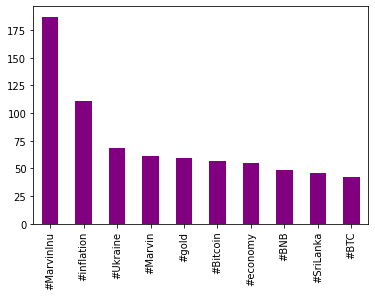

In [20]:
# we can plot the top 10 hashtags
df_['all_hashtags'].value_counts()[:10].plot(kind='bar',color='purple')

In [23]:
# plotting tweets by language
# first of all get the tweets by language
tweets_df = pd.DataFrame(columns = ['original_text','lang'])
tweets_df['text'] = df['original_text'].to_list()
tweets_df['lang'] = df['lang'].to_list()
tweets_according_language = tweets_df['lang'].value_counts()

<AxesSubplot:title={'center':'The 10 Most Frequent Used Languages In Tweets'}, xlabel='Languages', ylabel='Frequency'>

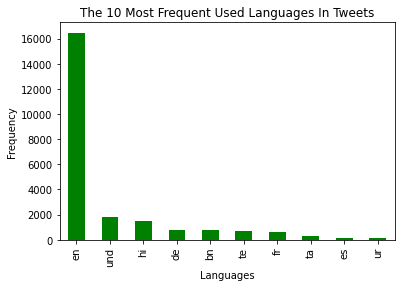

In [25]:
# we can plot the most frequent language
fig,ax = plt.subplots()
ax.tick_params(axis='x',labelsize=10)
ax.tick_params(axis='y',labelsize=10)
ax.set_xlabel("Languages")
ax.set_ylabel("Frequency")
ax.set_title("The 10 Most Frequent Used Languages In Tweets")
tweets_according_language[:10].plot(ax=ax,kind='bar',color='green')

In [30]:
import enchant

In [31]:
en_us = enchant.Dict("en_US")

In [32]:
# text processing
def clean_text(tweet):
    """this function cleans the original text"""
    return ' '.join(w for w in tweet.split() if en_us.check(w))

In [33]:
# apply the method to the original text
df_['clean_text'] = df_['original_text'].apply(clean_text)

In [42]:
# text processing
df_['clean_text'] = df_['clean_text'].astype(str)
df_['clean_text'] = df_['clean_text'].apply(lambda x:x.lower())
df_['clean_text'] = df_['clean_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))

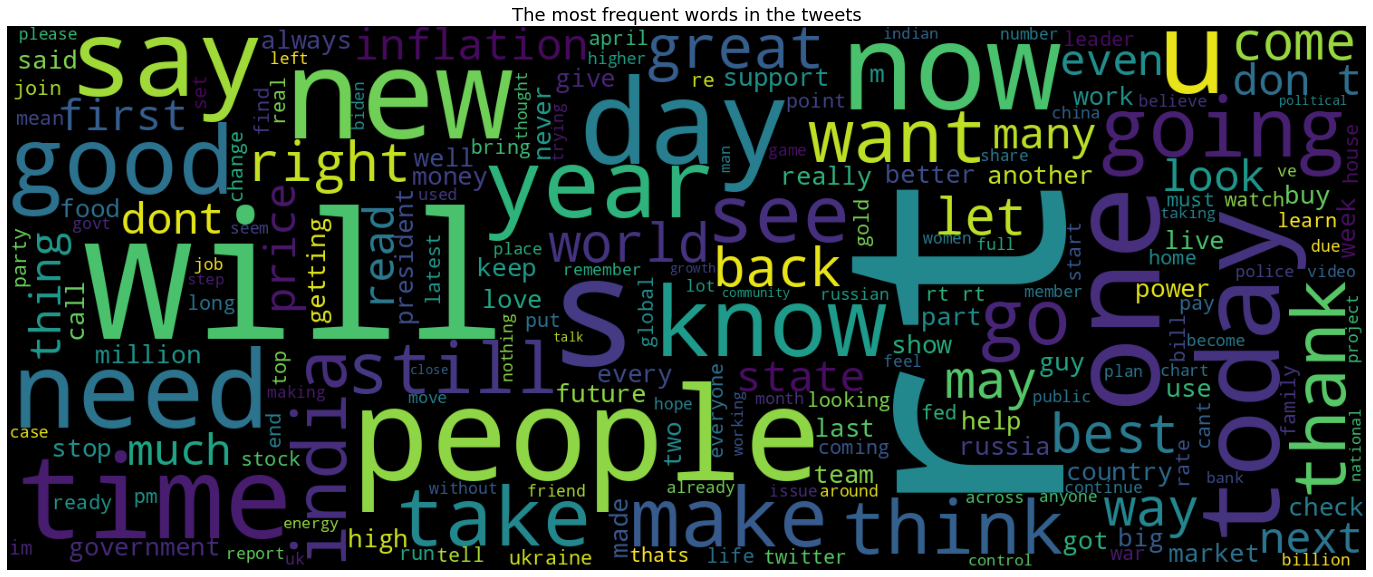

In [44]:
# plot the texts in a wordcloud
plt.figure(figsize=(30,10))
plt.imshow(WordCloud(width=1500,height=600,stopwords=STOPWORDS).generate(' '.join(df_['clean_text'].values)))
plt.axis('off')
plt.title("The most frequent words in the tweets",fontsize=18)
plt.show()

In [59]:
# create a bag of words
sentences = [tweet for tweet in df_['clean_text']]
words = [sentence.split() for sentence in sentences]
word_to_id_dict = corpora.Dictionary(words)
bag_of_words = [word_to_id_dict.doc2bow(tweet) for tweet in words]

In [55]:
# check bag of words
bag_of_words[1]

[(5, 1),
 (7, 1),
 (12, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 2),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1)]

In [61]:
# building an lda model
lda_model = LdaModel(bag_of_words,
                    id2word=word_to_id_dict,
                    num_topics=5,
                    random_state=100,
                    update_every=1,
                    chunksize=100,
                    passes=10,
                    alpha='auto',
                    per_word_topics=True)

In [64]:
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('the', 0.1598751),
   ('of', 0.086492695),
   ('is', 0.05656692),
   ('on', 0.04440463),
   ('rt', 0.019744327),
   ('from', 0.018245908),
   ('as', 0.015660278),
   ('follow', 0.014254792),
   ('an', 0.0095367115),
   ('up', 0.008887814)]),
 (1,
  [('for', 0.06332422),
   ('you', 0.036054168),
   ('are', 0.0330371),
   ('this', 0.030439295),
   ('it', 0.029385298),
   ('that', 0.027433055),
   ('not', 0.024864836),
   ('they', 0.015006766),
   ('its', 0.0142675545),
   ('if', 0.013212039)]),
 (2,
  [('i', 0.047256764),
   ('by', 0.0467053),
   ('was', 0.03224271),
   ('one', 0.029650392),
   ('10', 0.018487569),
   ('been', 0.016095225),
   ('man', 0.014344717),
   ('day', 0.012675604),
   ('cartoon', 0.01158829),
   ('their', 0.010572534)]),
 (3,
  [('to', 0.090749405),
   ('rt', 0.08937186),
   ('in', 0.064437725),
   ('a', 0.05562528),
   ('and', 0.048383728),
   ('with', 0.018049957),
   ('at', 0.017460072),
   ('have', 0.014407552),
   ('be', 0.013817203),
   ('has', 0.0

In [65]:
# perplexity computation
perplexity = lda_model.log_perplexity(bag_of_words)
perplexity

-7.717035386527352

In [68]:
# coherence score
coherence_model = CoherenceModel(model=lda_model,
                              texts=words,
                              dictionary=word_to_id_dict,
                              coherence='c_v')
coherence_lda = coherence_model.get_coherence()
coherence_lda

0.3499352915961066

In [ ]:
# explore intertopic distances
pyLDAvis.enable_notebook()
prepared = gensimvis.prepare(lda_model,bag_of_words,)